In [81]:
import os
import h5py
import glob
import pylab as pl
import numpy as np
import scipy.io
from scipy.ndimage.filters import gaussian_filter
import numpy as np
import scipy.interpolate as spinterp
from skimage.measure import block_reduce


In [61]:
%matplotlib notebook

In [62]:
rootdir = '/home/julianarhee/Documents/MATLAB/sparse_noise'
movie_fpath = glob.glob(os.path.join(rootdir, 'test_stimulus_001', '*.mat'))[0]
print movie_fpath

/home/julianarhee/Documents/MATLAB/sparse_noise/test_stimulus_001/test_discs.mat


In [63]:
mov = scipy.io.loadmat(movie_fpath)

mov.keys()

['MovieMag',
 '__version__',
 'degperpix',
 '__header__',
 '__globals__',
 'sz_mov',
 'MovieRate',
 'moviedata']

In [64]:
stimulus = mov['moviedata']
print stimulus.shape

(256, 128, 2400)


<IPython.core.display.Javascript object>


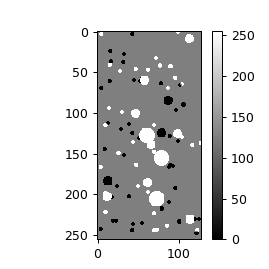

In [65]:
pl.figure(figsize=(3,3))
pl.imshow(stimulus[:, :, 0], cmap='gray')
pl.colorbar()

# Allen SDK functions

In [75]:
def convolve(img, sigma=4):
    '''
    2D Gaussian convolution
    '''

    if img.sum() == 0:
        return img

    img_pad = np.zeros((3 * img.shape[0], 3 * img.shape[1]))
    img_pad[img.shape[0]:2 * img.shape[0], img.shape[1]:2 * img.shape[1]] = img

    x = np.arange(3 * img.shape[0])
    y = np.arange(3 * img.shape[1])
    g = spinterp.interp2d(y, x, img_pad, kind='linear')

    if img.shape[0] == 16:
        upsample = 4
        offset = -(1 - .625)
    elif img.shape[0] == 8:
        upsample = 8
        offset = -(1 - .5625)
    else:
        upsample=1
        offset=0
        #raise NotImplementedError
    ZZ_on = g(offset + np.arange(0, img.shape[1] * 3, 1. / upsample), offset + np.arange(0, img.shape[0] * 3, 1. / upsample))
    ZZ_on_f = gaussian_filter(ZZ_on, float(sigma), mode='constant')

    z_on_new = block_reduce(ZZ_on_f, (upsample, upsample))
    z_on_new = z_on_new / z_on_new.sum() * img.sum()
    z_on_new = z_on_new[img.shape[0]:2 * img.shape[0], img.shape[1]:2 * img.shape[1]]

    return z_on_new

In [76]:
74.4/8

9.3

In [77]:
def get_A(stimulus_template):
    npixels = stimulus_template.shape[0]*stimulus_template.shape[1]
    A = np.zeros((2*npixels, stimulus_template.shape[-1]))
    for fi in np.arange(0, stimulus_template.shape[-1]):
        A[:npixels, fi] = (stimulus_template[:, :, fi].flatten() > 127).astype(float)
        A[npixels:, fi] = (stimulus_template[:, :, fi].flatten() < 127).astype(float)
    return A

In [78]:
def get_A_blur(stimulus_template):
    A = get_A(stimulus_template).copy()
    npixels = A.shape[0] // 2
    for fi in range(A.shape[1]):
        A[:npixels,fi] = convolve(A[:npixels, fi].reshape(stimulus_template.shape[1], stimulus_template.shape[0])).flatten()
        A[npixels:,fi] = convolve(A[npixels:, fi].reshape(stimulus_template.shape[1], stimulus_template.shape[0])).flatten()

    return A

In [79]:
A = get_A(stimulus).copy()
npixels =  A.shape[0] // 2


In [72]:
img = A[:npixels, 0].reshape(stimulus.shape[1], stimulus.shape[0])
print img.sum()
print img.shape

2300.0
(128, 256)


In [73]:

img_pad = np.zeros((3 * img.shape[0], 3 * img.shape[1]))
img_pad[img.shape[0]:2 * img.shape[0], img.shape[1]:2 * img.shape[1]] = img
print img_pad.shape

(384, 768)


In [74]:
x = np.arange(3 * img.shape[0])
y = np.arange(3 * img.shape[1])
g = spinterp.interp2d(y, x, img_pad, kind='linear')


In [ ]:
    if img.shape[0] == 16:
        upsample = 4
        offset = -(1 - .625)
    elif img.shape[0] == 8:
        upsample = 8
        offset = -(1 - .5625)
    else:
        raise NotImplementedError
        

In [89]:
128*256*2

65536

In [83]:
A_blur = get_A_blur(stimulus)
number_of_pixels = A_blur.shape[0] // 2
print A_blur.shape

(65536, 2400)


In [86]:
d1, d2, d3 = stimulus.shape

<IPython.core.display.Javascript object>


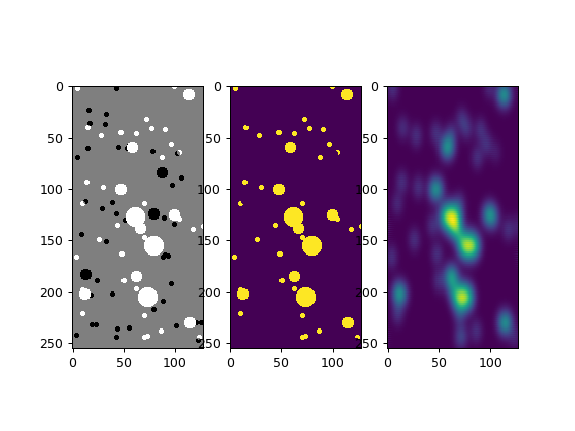

In [91]:
fig, axes = pl.subplots(1,3) #pl.figure()
ax = axes[0]
ax.imshow(stimulus[:, :, 0], cmap='gray')

ax = axes[1]
ax.imshow(A[0:npixels, 0].reshape((d1, d2)))

ax = axes[2]
ax.imshow(A_blur[0:npixels, 0].reshape((d1, d2)))